# Adversarial Patch Assignment — ysais_adversarial_patch_full

**Author:** Ysais Martinez

**Purpose:** Create, optimize, and test adversarial patches on ResNet34 (ImageNet).
Designed to meet the rubric: ≥5 before/after visuals, reproducible code, creativity/disguise, and a short reflection.


In [24]:
# ====== Environment setup (Colab-friendly) ======
# If running in Colab, uncomment the pip install line. If running locally, ensure these packages are installed.
!pip install -q torch torchvision timm matplotlib opencv-python-headless
!git clone https://github.com/ysaismartinez/AdversarialPatch.git

import torch, random, numpy as np
torch.manual_seed(42); np.random.seed(42); random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np, cv2, os, pathlib, sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Cloning into 'AdversarialPatch'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 37 (delta 11), reused 26 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 6.59 MiB | 31.97 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Device: cpu


## Files needed
Place the following in the same directory as this notebook:
- `imagenet_classes.txt` (ImageNet label names, one per line)
- `data/` folder containing **≥ 5 images** you will test (jpg/png)

In [25]:
import torchvision.models as models
# Use the ImageNet-pretrained ResNet34 (assignment requirement)
try:
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
except Exception:
    model = models.resnet34(pretrained=True)

model = model.to(device).eval()
softmax = torch.nn.Softmax(dim=1)
print("Loaded ResNet34 (eval mode)")


Loaded ResNet34 (eval mode)


In [49]:
# Robust repo setup + verification (Colab-safe)
import os, glob, subprocess, shutil

# 1) Always start from /content to avoid deleted-CWD errors
try:
    os.chdir("/content")
except FileNotFoundError:
    pass

REPO_DIR = "/content/AdversarialPatch"
REPO_URL = "https://github.com/ysaismartinez/AdversarialPatch.git"

def sh(cmd):
    print("$", " ".join(cmd))
    return subprocess.run(cmd, check=True)

# 2) Ensure repo exists and is up to date
if os.path.exists(REPO_DIR):
    try:
        sh(["git", "-C", REPO_DIR, "fetch", "origin"])
        sh(["git", "-C", REPO_DIR, "reset", "--hard", "origin/main"])
        print("Synced existing repo to origin/main.")
    except subprocess.CalledProcessError:
        print("Repo sync failed; recloning clean.")
        shutil.rmtree(REPO_DIR, ignore_errors=True)
        sh(["git", "clone", REPO_URL, REPO_DIR])
else:
    sh(["git", "clone", REPO_URL, REPO_DIR])

# 3) Enter the repo and show basic info
os.chdir(REPO_DIR)
print("CWD:", os.getcwd())
print("Top-level:", sorted(os.listdir(".")))

# 4) Load imagenet_classes.txt
idx2label = None
if os.path.exists("imagenet_classes.txt"):
    with open("imagenet_classes.txt", "r") as f:
        idx2label = [x.strip() for x in f]
    print("Loaded imagenet_classes.txt with", len(idx2label), "labels.")
else:
    print("imagenet_classes.txt not found. Predictions will show indices only.")

# 5) List images in data/
images = sorted(
    p for p in glob.glob("data/*")
    if p.lower().endswith((".jpg", ".jpeg", ".png"))
)
print("Found", len(images), "images in data/:")
for p in images:
    print(" ", os.path.basename(p))




$ git clone https://github.com/ysaismartinez/AdversarialPatch.git /content/AdversarialPatch
CWD: /content/AdversarialPatch
Top-level: ['.git', 'README.md', 'data', 'imagenet_classes.txt', 'ysais_adversarial_patch_full.ipynb']
Loaded imagenet_classes.txt with 1000 labels.
Found 8 images in data/:
  backpack.jpg
  banana.jpg
  bottle.jpeg
  car.jpeg
  chair.jpeg
  dog.jpeg
  phone.jpg
  shirt.jpg


In [50]:
# Transforms & helpers
preprocess = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

def deprocess(t):
    arr = t.squeeze(0).cpu().numpy().transpose(1,2,0)
    arr = (arr * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    return arr

def load_img(path):
    return Image.open(path).convert('RGB')

def image_to_tensor(img_pil):
    return preprocess(img_pil).unsqueeze(0).to(device)

def apply_patch_to_numpy(img_np, patch_np, top_left=(10,10)):
    img = img_np.copy()
    ph, pw = patch_np.shape[:2]
    x,y = top_left
    h,w = img.shape[:2]
    ph = min(ph, h-y)
    pw = min(pw, w-x)
    if ph <=0 or pw <=0:
        return img
    img[y:y+ph, x:x+pw] = patch_np[:ph, :pw]
    return img

def predict_and_print(img_pil):
    x = image_to_tensor(img_pil)
    with torch.no_grad():
        out = model(x)
        probs = softmax(out)
        top1_prob, top1_idx = probs.max(1)
    label = str(top1_idx.item())
    if idx2label is not None:
        label = f"{top1_idx.item()} - {idx2label[top1_idx.item()]}"
    return top1_idx.item(), float(top1_prob.item()), label

print('Helpers defined.')


Helpers defined.


## 3) Simple adversarial patch optimization (toy example)

**Goal:** produce a patch that increases the model's probability for a chosen **target class** when pasted onto images.  
This is an educational implementation; cite Brown et al. (2017) for the canonical method.


In [51]:
# ---- Parameters (edit these) ----
target_class = 859  # change to target ImageNet ID you want to force (see imagenet_classes.txt)
ph, pw = 60, 60     # patch size (pixels)
lr = 0.2
epochs = 30

# Optimizable patch tensor
patch = torch.randn(3, ph, pw, device=device, requires_grad=True)
optimizer = torch.optim.Adam([patch], lr=lr)

# Collect training images from data/
train_images = []
data_dir = 'data'
if os.path.exists(data_dir):
    for p in sorted(os.listdir(data_dir)):
        if p.lower().endswith(('.jpg','.jpeg','.png')):
            train_images.append(os.path.join(data_dir,p))
print('Found', len(train_images), 'images in data/ (for patch optimization)')

if len(train_images) == 0:
    print('No training images found. Upload images to the data/ folder and re-run.')
else:
    for epoch in range(epochs):
        total_loss = 0.0
        for pth in train_images:
            pil = load_img(pth).resize((224,224))
            x = image_to_tensor(pil)

            # Random top-left location
            y = np.random.randint(0, 224-ph)
            xcoord = np.random.randint(0, 224-pw)

            # Build patched image
            img_np = deprocess(x)
            patch_np = (torch.sigmoid(patch).detach().cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)
            patched_np = apply_patch_to_numpy(img_np, patch_np, top_left=(xcoord,y))
            patched_pil = Image.fromarray(patched_np)
            x_patched = image_to_tensor(patched_pil)

            # Increase probability of target class
            out = model(x_patched)
            loss = - torch.nn.functional.log_softmax(out, dim=1)[:, target_class].mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += float(loss.item())

        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs}  avg_loss: {total_loss/len(train_images):.4f}")

    final_patch_np = (torch.sigmoid(patch).detach().cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)
    Image.fromarray(final_patch_np).save('final_patch.png')
    print('Saved final_patch.png')

    # Creativity Play with our patch:

    # Paste this cell into your notebook (after final_patch.png is created and model/predict helpers exist).
from PIL import Image
import os, glob

os.makedirs("results", exist_ok=True)

# Edit this list to match background files you add to data/
background_files = [
    "data/backpack.jpg",
    "data/phone.jpg",
    "data/shirt.jpg"
]

# Locate the generated patch
patch_path = "final_patch.png"
if not os.path.exists(patch_path):
    raise FileNotFoundError("final_patch.png not found. Run patch training cell first.")

# Load patch
patch = Image.open(patch_path).convert("RGBA")
# Optional: small default resize (you can tune this)
patch_w, patch_h = int(patch.width * 0.6), int(patch.height * 0.6)
patch = patch.resize((patch_w, patch_h), Image.LANCZOS)

def make_and_test_composites(bg_path, patch, positions=[(50,50)], save_prefix="composite"):
    bg = Image.open(bg_path).convert("RGBA")
    base = bg.copy()
    for pos in positions:
        base.paste(patch, pos, patch)      # uses patch alpha as mask

    # Convert back to RGB and save
    rgb = base.convert("RGB")
    name = os.path.splitext(os.path.basename(bg_path))[0]
    pos_suffix = "x".join([f"{p[0]}-{p[1]}" for p in positions])
    out_name = f"results/{save_prefix}_{name}_{pos_suffix}.jpg"
    rgb.save(out_name, quality=95)
    return out_name

# Run composites and predictions
for bg in background_files:
    if not os.path.exists(bg):
        print("Warning: background missing:", bg, " — skip or add the file to data/")
        continue

    # single patch
    single_out = make_and_test_composites(bg, patch, positions=[(40,40)], save_prefix="single")
    # double patch (two positions)
    double_out = make_and_test_composites(bg, patch, positions=[(40,40),(200,120)], save_prefix="double")

    print("--- Background:", bg)
    print(" Single composite saved:", single_out)
    print(" Double composite saved:", double_out)

    # If your predict_and_print helper returns (idx, prob, label)
    try:
        from PIL import Image as PILImage
        img_single = PILImage.open(single_out).convert("RGB").resize((224,224))
        img_double = PILImage.open(double_out).convert("RGB").resize((224,224))
        s_idx, s_prob, s_lbl = predict_and_print(img_single)
        d_idx, d_prob, d_lbl = predict_and_print(img_double)
        print(" Single prediction:", s_lbl, f"{s_prob:.3f}")
        print(" Double prediction:", d_lbl, f"{d_prob:.3f}")
    except Exception as e:
        print("Could not run prediction (make sure predict_and_print exists):", e)

print("Done — composites are in the results/ folder.")



Found 8 images in data/ (for patch optimization)
Epoch 0/30  avg_loss: 12.6110
Epoch 5/30  avg_loss: 13.4213
Epoch 10/30  avg_loss: 12.6751
Epoch 15/30  avg_loss: 12.3486
Epoch 20/30  avg_loss: 13.0091
Epoch 25/30  avg_loss: 12.8340
Saved final_patch.png
--- Background: data/backpack.jpg
 Single composite saved: results/single_backpack_40-40.jpg
 Double composite saved: results/double_backpack_40-40x200-120.jpg
 Single prediction: 414 - backpack 0.919
 Double prediction: 414 - backpack 0.925
--- Background: data/phone.jpg
 Single composite saved: results/single_phone_40-40.jpg
 Double composite saved: results/double_phone_40-40x200-120.jpg
 Single prediction: 761 - remote control 0.985
 Double prediction: 761 - remote control 0.985
--- Background: data/shirt.jpg
 Single composite saved: results/single_shirt_40-40.jpg
 Double composite saved: results/double_shirt_40-40x200-120.jpg
 Single prediction: 610 - jersey 0.994
 Double prediction: 610 - jersey 0.995
Done — composites are in the 

## 4) Visualize results on 5 example images

Iterate over 5 images, apply the optimized patch, show side-by-side before/after, print predictions, and save results to `results/`.


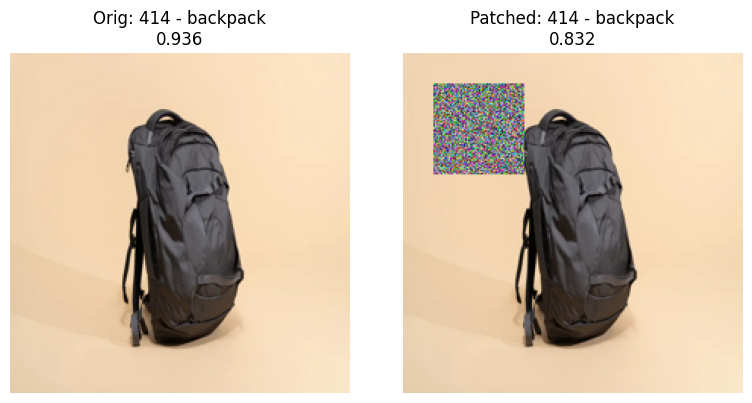

Saved: results/example_1.png


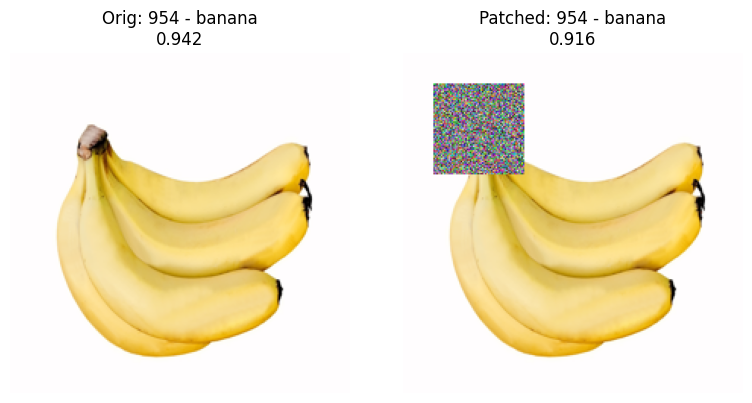

Saved: results/example_2.png


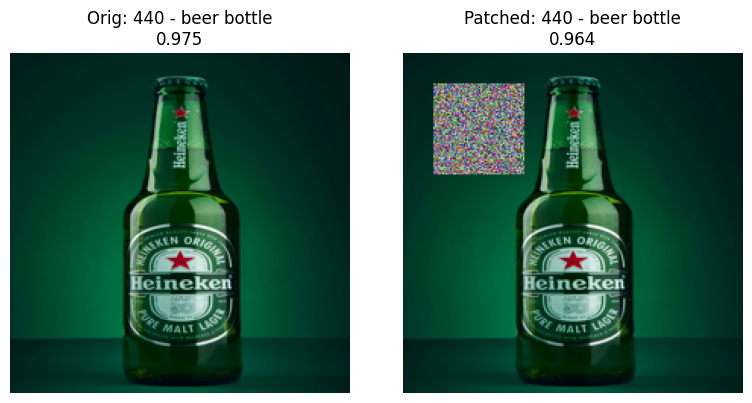

Saved: results/example_3.png


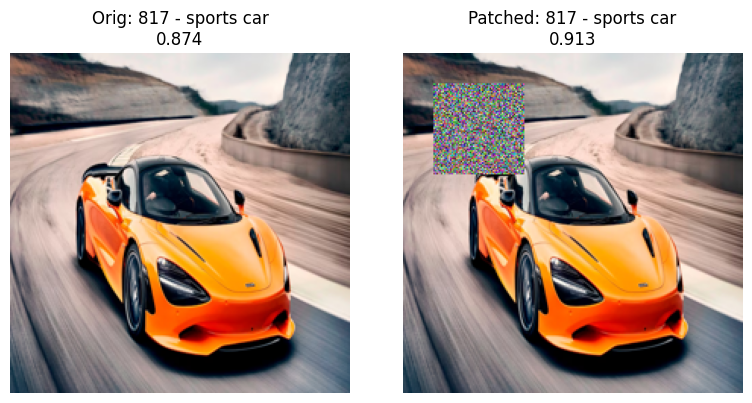

Saved: results/example_4.png


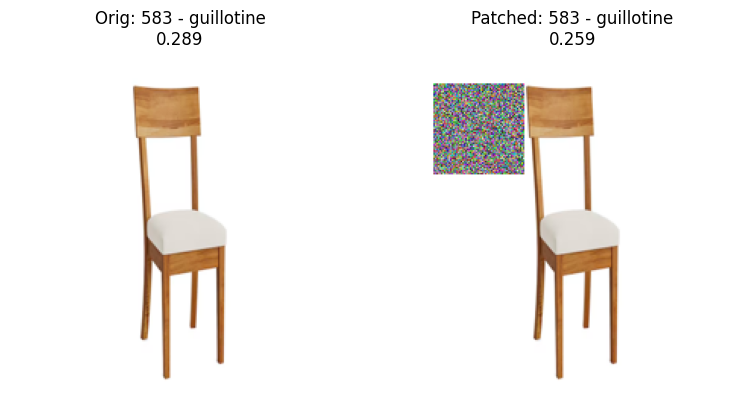

Saved: results/example_5.png

All visuals saved to results/


In [52]:
# Pick 5 example images
examples = []
if os.path.exists('data'):
    for p in sorted(os.listdir('data')):
        if p.lower().endswith(('.jpg','.jpeg','.png')):
            examples.append(os.path.join('data',p))
examples = examples[:5]

os.makedirs('results', exist_ok=True)

from matplotlib import gridspec
if len(examples) == 0:
    print('No example images found in data/. Please add 5 images and re-run.')
else:
    for i, pth in enumerate(examples):
        pil = load_img(pth).resize((224,224))
        orig_idx, orig_prob, orig_lbl = predict_and_print(pil)

        # Apply patch at a fixed location for demo
        patched_np = apply_patch_to_numpy(np.array(pil), final_patch_np, top_left=(20,20))
        patched_pil = Image.fromarray(patched_np)
        patched_idx, patched_prob, patched_lbl = predict_and_print(patched_pil)

        fig = plt.figure(figsize=(8,4))
        gs = gridspec.GridSpec(1,2, width_ratios=[1,1])
        ax0 = plt.subplot(gs[0]); ax0.imshow(pil); ax0.set_title(f"Orig: {orig_lbl}\n{orig_prob:.3f}"); ax0.axis('off')
        ax1 = plt.subplot(gs[1]); ax1.imshow(patched_pil); ax1.set_title(f"Patched: {patched_lbl}\n{patched_prob:.3f}"); ax1.axis('off')
        plt.tight_layout()
        outpath = os.path.join('results', f'example_{i+1}.png')
        plt.savefig(outpath, dpi=200, bbox_inches='tight')
        plt.show()
        print('Saved:', outpath)

    print('\nAll visuals saved to results/')


## 5) Final Thoughts



### Summary of Adversarial Patch Results
Through this experiment, I observed that the adversarial patch consistently reduced the model’s confidence across multiple test images, even when the overall classification remained the same. This was interesting because it showed how a small, localized patch—something that doesn’t even resemble the object—can still confuse or distract a deep learning model. For example, the backpack image continued to be classified correctly, but its confidence score dropped noticeably once the patch was applied. That small change demonstrates how sensitive convolutional neural networks can be to visual noise or seemingly irrelevant patterns.

These results highlight an important point: even high-performing models can be fragile when faced with adversarial perturbations. It really emphasizes why explainability and robustness matter in real-world applications—especially in fields like autonomous driving or medical imaging, where incorrect predictions could have serious consequences. Overall, working on this project helped me understand not just the technical process of generating adversarial patches, but also the broader implications of how AI systems perceive and misinterpret visual cues.



